# 🛠️ Phase 4: Feature Engineering - Laboratorio de Experimentos

En esta fase transformamos los datos limpios y la información macroeconómica en características (features) que el modelo pueda procesar. 

**Objetivos:**
1. Crear variables de calendario (Festivos, Fines de semana, Semana Santa).
2. Implementar 'Flags' estructurales (COVID, Retail).
3. Integrar variables macroeconómicas relevantes.
4. Exportar el dataset final en formato `.parquet` para el modelado.

In [1]:
import os
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from datetime import datetime

# Configuración Visual
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Cargar Configuración
with open('../config.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

fe_conf = config['feature_engineering']
paths = config['paths']

print("✅ Configuración cargada correctamente.")

✅ Configuración cargada correctamente.


In [2]:
# 1️⃣ Carga de Entradas
sales_path = os.path.join("..", paths['cleansed_data'], fe_conf['input']['sales_file'])
macro_path = os.path.join("..", paths['features_data'], fe_conf['input']['macro_file'])

df_sales = pd.read_csv(sales_path, parse_dates=['fecha'], index_col='fecha')
df_macro = pd.read_csv(macro_path, parse_dates=['fecha'], index_col='fecha')

df_sales.sort_index(inplace=True)
df_macro.sort_index(inplace=True)

print(f"📈 Ventas cargadas: {df_sales.shape[0]} registros.")
print(f"🌍 Macro cargado: {df_macro.shape[0]} registros.")

📈 Ventas cargadas: 83 registros.
🌍 Macro cargado: 96 registros.


### 2️⃣ Ingeniería de Calendario
Creamos variables que capturan el ritmo de vida en Colombia.

In [3]:
def get_calendar_features(df):
    df = df.copy()
    co_holidays = holidays.Colombia()
    
    # Crear rango de fechas diarias para el mes
    df['festivos_conteo'] = 0
    df['fines_semana_conteo'] = 0
    df['es_semana_santa'] = 0
    
    for date in df.index:
        # Generar todos los días del mes actual
        days_in_month = pd.date_range(start=date, periods=date.days_in_month, freq='D')
        
        # Conteo de Festivos
        festivos = sum(1 for d in days_in_month if d in co_holidays)
        df.at[date, 'festivos_conteo'] = festivos
        
        # Conteo de Fines de Semana (Sábados=5, Domingos=6)
        fines_semana = sum(1 for d in days_in_month if d.dayofweek >= 5)
        df.at[date, 'fines_semana_conteo'] = fines_semana
        
        # Semana Santa (Estimación simplificada: Si el mes es Marzo o Abril y contiene el Viernes Santo)
        # Usamos la lógica de holidays que ya incluye el Jueves/Viernes Santo
        is_holy_week = any("Jueves Santo" in co_holidays.get(d, "") or "Viernes Santo" in co_holidays.get(d, "") for d in days_in_month)
        df.at[date, 'es_semana_santa'] = 1 if is_holy_week else 0
        
    # Feria de las Flores (Agosto en Medellín)
    df['es_feria_flores'] = (df.index.month == 8).astype(int)
    
    return df

df_sales = get_calendar_features(df_sales)
print("✅ Variables de calendario creadas.")
df_sales[['festivos_conteo', 'fines_semana_conteo', 'es_semana_santa', 'es_feria_flores']].head()

✅ Variables de calendario creadas.


,festivos_conteo,fines_semana_conteo,es_semana_santa,es_feria_flores
fecha,,,,
2018-12-01,2,10,0,0
2019-01-01,2,8,0,0
2019-02-01,0,8,0,0
2019-03-01,1,10,0,0
2019-04-01,2,8,1,0


### 3️⃣ Hitos Estructurales (Flags)
Marcamos los periodos que cambiaron la base de las ventas.

In [4]:
flags = fe_conf['structural_flags']

# Flag COVID
df_sales['flag_covid'] = 0
covid_start = pd.to_datetime(flags['covid_impact']['start'])
covid_end = pd.to_datetime(flags['covid_impact']['end'])
df_sales.loc[(df_sales.index >= covid_start) & (df_sales.index <= covid_end), 'flag_covid'] = 1

# Flag Retail (Gran Superficie)
df_sales['flag_retail'] = 0
retail_start = pd.to_datetime(flags['retail_expansion']['start'])
df_sales.loc[df_sales.index >= retail_start, 'flag_retail'] = 1

print("✅ Flags estructurales creados.")
df_sales[['flag_covid', 'flag_retail']].sample(5)

✅ Flags estructurales creados.


,flag_covid,flag_retail
fecha,,
2020-03-01,0,0
2020-07-01,1,0
2025-01-01,0,1
2019-12-01,0,0
2021-10-01,0,0


### 4️⃣ Integración Macroeconómica
Unimos las variables económicas seleccionadas.

In [5]:
macro_cols = fe_conf['macro_selection']['columns']
df_final = df_sales.join(df_macro[macro_cols], how='left')

# Verificación de Nulos post-unión
if df_final[macro_cols].isna().any().any():
    print("⚠️ Advertencia: Se detectaron nulos en variables macro. Aplicando ffill.")
    df_final[macro_cols] = df_final[macro_cols].ffill().bfill()

print("✅ Integración macroeconómica completada.")
df_final.head()

✅ Integración macroeconómica completada.


,unidades,es_atipico,festivos_conteo,fines_semana_conteo,es_semana_santa,es_feria_flores,flag_covid,flag_retail,ipc_mensual,trm_promedio,tasa_desempleo,costo_insumos_index,mes_de_prima
fecha,,,,,,,,,,,,,
2018-12-01,29549,0,2,10,0,0,0,0,0.353427,3413.735477,11.768421,105.930045,1
2019-01-01,21716,0,2,8,0,0,0,0,0.424196,3437.494346,11.747368,106.481555,0
2019-02-01,12292,0,0,8,0,0,0,0,0.208672,3458.088102,11.726316,106.966665,0
2019-03-01,15179,0,1,10,0,0,0,0,0.227508,3475.428602,11.705263,107.082911,0
2019-04-01,11843,0,2,8,1,0,0,0,0.343771,3489.463718,11.684211,107.577608,0


### 5️⃣ Visualización de Relevancia
¿Cómo se ven las nuevas variables frente a las ventas?

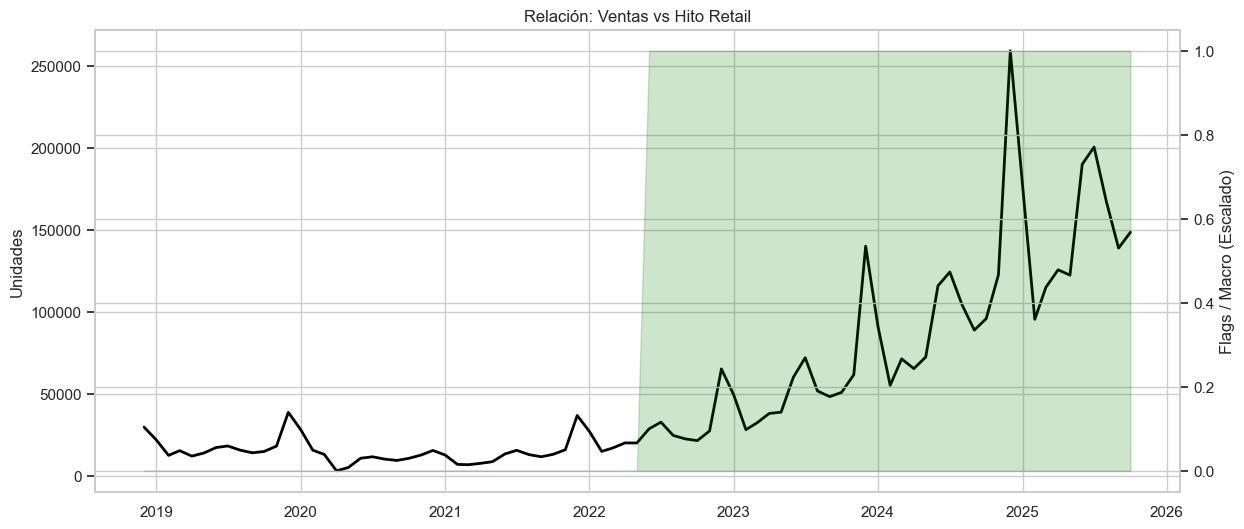

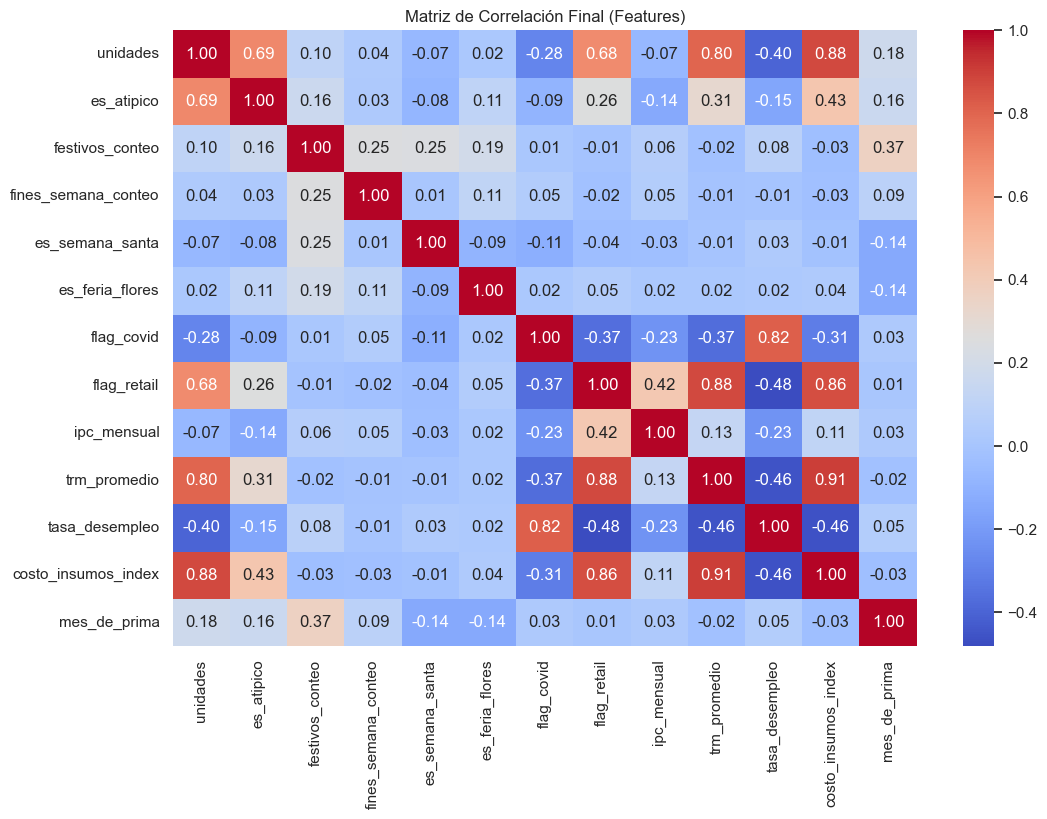

In [6]:
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(df_final.index, df_final['unidades'], label='Ventas', color='black', linewidth=2)
ax1.set_ylabel('Unidades')

ax2 = ax1.twinx()
ax2.fill_between(df_final.index, 0, df_final['flag_retail'], alpha=0.2, color='green', label='Retail Expansion')
ax2.set_ylabel('Flags / Macro (Escalado)')

plt.title('Relación: Ventas vs Hito Retail')
plt.show()

# Correlación de Pearson Final
plt.figure(figsize=(12, 8))
sns.heatmap(df_final.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación Final (Features)')
plt.show()

### 6️⃣ Exportación Final
Guardamos en formato Parquet y generamos reporte.

In [7]:
output_dir = os.path.join("..", paths['processed_data'])
os.makedirs(output_dir, exist_ok=True)

output_file = os.path.join(output_dir, fe_conf['output']['filename'])
df_final.to_parquet(output_file)

print(f"🚀 Dataset final exportado a: {output_file}")

# Crear Reporte JSON simplificado
report = {
    "phase": "04_Feature_Engineering",
    "timestamp": datetime.now().isoformat(),
    "final_rows": df_final.shape[0],
    "final_columns": df_final.columns.tolist(),
    "features_created": {
        "calendar": fe_conf['calendar']['features'],
        "structural": list(flags.keys()),
        "macro": macro_cols
    }
}

import json
report_path = os.path.join("..", paths['reports'], fe_conf['output']['report_name'])
with open(report_path, 'w') as f:
    json.dump(report, f, indent=4)

print(f"📝 Reporte de fase guardado en: {report_path}")

🚀 Dataset final exportado a: ..\data/04_processed/ventas_features.parquet
📝 Reporte de fase guardado en: ..\outputs/reports/phase_04_summary_fe.json
